In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import product
import statsmodels.api as sm
from PortfolioAnalysis import *

from DataPipeline import DataPipeline, MSE, R2, r2_metrics

file_path = '/Users/zequnli/LocalData/'

2024-07-22 17:17:07.326317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import statsmodels.api as sm
import scipy.stats as stats
def newey_west_t_stat(y, maxlag=None):
    x = np.ones_like(y)
    nobs = len(y)
    lags = int(np.ceil(12 * np.power(nobs / 100, 1/4))) # choose number of lags, this is just an example
    model = sm.OLS(y, x)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags':lags, 'use_correction':True})

    # Calculate the Newey-West t-statistic for the mean of y
    t = results.params[0] / results.bse[0]
    p_value = 2 * (1 - stats.t.cdf(np.abs(t), nobs - 1))


        # Return a pandas Series with named elements
    return pd.Series({
        'mean': np.mean(y),
        'bse': results.bse[0],
        't_stats': t,
        'p_value': p_value,
        'SR': np.sqrt(12)*np.mean(y)/np.std(y)
    })

# ML OOS Prediction

In [16]:
# load data
dataset = DataPipeline(file_path)
train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
train_N = train_mask.sum()
validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
validation_N = validation_mask.sum()
test_mask = (dataset.data['yyyymm'] > 198900)
test_N = test_mask.sum()
N = dataset.data.shape[0]

In [17]:
# initiate a result dataframe
# yyyymm and permno for merging purpose
# me and exret for calculating portfolio return
OOSresults = dataset.data[['yyyymm','permno','me','exret']][test_mask].copy()

### NN3

In [18]:
from tensorflow.keras.models import load_model

y_test = []
y_pred = []
for year in range(1989,2022):
    model = load_model(file_path+'NN3_model/NN3_'+str(year)+'.keras', custom_objects={'r2_metrics': r2_metrics})
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

2024-06-08 15:22:57.316082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2440/2440 [==============================] - 2s 595us/step


In [19]:
OOSresults = OOSresults.assign(pred_nn3 = np.array(y_pred).reshape(-1))

### RF

In [7]:
from joblib import load
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load(file_path+'RF_model/RF_'+str(year)+'.joblib')
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

In [8]:
OOSresults = OOSresults.assign(pred_rf = np.array(y_pred).reshape(-1))

### RF2

In [10]:
from joblib import load
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load(file_path+'RF2_model/RF2_'+str(year)+'.joblib')
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

In [11]:
OOSresults = OOSresults.assign(pred_rf2 = np.array(y_pred).reshape(-1))

### RF3

In [20]:
from joblib import load
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load(file_path+'RF3_model/RF3_'+str(year)+'.joblib')
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

In [21]:
OOSresults = OOSresults.assign(pred_rf = np.array(y_pred).reshape(-1))

## Save results

In [22]:
# Save the results
OOSresults.to_csv(file_path+'OOSresults.csv')

# OOS Comparison

In [5]:
OOSresults = pd.read_csv(file_path+'OOSresults.csv', index_col=0)
# convert yyyymm into datetime
OOSresults['date'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)

In [10]:
# load data
dataset = DataPipeline(file_path)

In [1]:
def naive_prediction(OOSresults):
    return np.zeros(OOSresults.shape[0])

In [11]:
def FM_prediction(OOSresults):
    params = {}
    result_insample = []
    for year,month in product(range(1963,2022),range(1,13)):
        if year == 1963 and month < 7:
            continue
        X,Y, _ = dataset.LoadOneMonthXY(year,month)
        X = sm.add_constant(X)
        lr = sm.OLS(Y,X).fit()
        params[year*100+month] = lr.params
        result_insample.extend(lr.predict(X))
    params = pd.DataFrame(params).T

    result_oos = []
    for year,month in product(range(1989,2022),range(1,13)):
        X,Y, month_result = dataset.LoadOneMonthXY(year,month)
        X = sm.add_constant(X)
        param = params.rolling(12).mean().shift().loc[year*100+month]
        result_oos.extend(X.dot(param))
    return result_oos

In [13]:
def FM5_prediction(OOSresults):
    params = {}
    result_insample = []
    for year,month in product(range(1963,2022),range(1,13)):
        if year == 1963 and month < 7:
            continue
        X,Y, _ = dataset.LoadOneMonthXY(year,month)
        X = sm.add_constant(X[['mvel1','bm','mom12m','operprof','agr']])
        lr = sm.OLS(Y,X).fit()
        params[year*100+month] = lr.params
        result_insample.extend(lr.predict(X))
    params = pd.DataFrame(params).T

    result_oos = []
    for year,month in product(range(1989,2022),range(1,13)):
        X,Y, month_result = dataset.LoadOneMonthXY(year,month)
        X = X[['mvel1','bm','mom12m','operprof','agr']]
        if year < 1975:
            result_oos.extend(np.zeros(X.shape[0]))
            continue
        X = sm.add_constant(X)
        param = params.rolling(12).mean().shift().loc[year*100+month]
        result_oos.extend(X.dot(param))
    return result_oos
        

In [4]:

train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
train_N = train_mask.sum()
validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
validation_N = validation_mask.sum()
test_mask = (dataset.data['yyyymm'] > 198900)
test_N = test_mask.sum()
N = dataset.data.shape[0]

In [16]:
FullSample_oos_count = OOSresults.groupby('date')['exret'].count()

## R-squared

#### Naive

In [7]:
OOSresults = OOSresults.assign(pred_naive = naive_prediction(OOSresults))

#### FM

In [12]:
OOSresults = OOSresults.assign(pred_fm = FM_prediction(OOSresults))
# 54.7s

#### FM5

In [14]:
OOSresults = OOSresults.assign(pred_fm5 = FM5_prediction(OOSresults))
# 15s

#### MLs

In [15]:
# Initiate a comparison dataframe
comparison = {}
# naive prediction
comparison['Naive'] = {}
comparison['Naive']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_naive'])
comparison['Naive']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_naive'])*100
comparison['FM'] = {}
comparison['FM']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm'])*100
comparison['FM5'] = {}
comparison['FM5']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['FM5']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm5'])*100
comparison['NN3'] = {}
comparison['NN3']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['NN3']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_nn3'])*100
comparison['RF'] = {}
comparison['RF']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf'])*100

### OOS R-squared and MSE Summarize Full Sample

In [16]:
pd.DataFrame(comparison).round(2).to_clipboard()
pd.DataFrame(comparison).round(2)

,Naive,FM,FM5,NN3,RF
testing MSE,344.63,348.14,347.27,342.96,343.21
testing R2,0.00,-1.02,-0.77,0.49,0.41


### OOS R-squared and MSE Summarize Top 1000

,NN3,RF
testing MSE,517.64,515.58
testing R2,-0.04,0.36


In [48]:
# in OOS result, find the rows that in each yyyymm, sort by me is in top 1000
OOSresults['me_rank'] = OOSresults.groupby('yyyymm')['me'].transform(lambda x: x.rank(ascending=False))
OOSresults_top = OOSresults[OOSresults['me_rank']<=1000].copy()
# Initiate a comparison dataframe
top_comparison = {}
# naive prediction
top_comparison['Naive'] = {}
top_comparison['Naive']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_naive'])
top_comparison['Naive']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_naive'])*100
top_comparison['FM'] = {}
top_comparison['FM']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_fm'])
top_comparison['FM']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_fm'])*100
top_comparison['FM5'] = {}
top_comparison['FM5']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_fm5'])
top_comparison['FM5']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_fm5'])*100
top_comparison['NN3'] = {}
top_comparison['NN3']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_nn3'])
top_comparison['NN3']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_nn3'])*100
top_comparison['RF'] = {}
top_comparison['RF']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_rf'])
top_comparison['RF']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_rf'])*100
pd.DataFrame(top_comparison).round(2).to_clipboard()
pd.DataFrame(top_comparison).round(2)

,Naive,FM,FM5,NN3,RF
testing MSE,137.56,139.93,139.43,136.72,136.06
testing R2,0.00,-1.72,-1.36,0.61,1.09


### OOS R-squared and MSE Summarize Bottom 1000

In [50]:
# in OOS result, find the rows that in each yyyymm, sort by me is in top 1000
OOSresults['me_rank'] = OOSresults.groupby('yyyymm')['me'].transform(lambda x: x.rank(ascending=True))
OOSresults_bottom = OOSresults[OOSresults['me_rank']<=1000].copy()
# Initiate a comparison dataframe
bottom_comparison = {}
# naive prediction
bottom_comparison['Naive'] = {}
bottom_comparison['Naive']['testing MSE'] = MSE(OOSresults_bottom['exret'], OOSresults_bottom['pred_naive'])
bottom_comparison['Naive']['testing R2'] = R2(OOSresults_bottom['exret'], OOSresults_bottom['pred_naive'])*100
bottom_comparison['FM'] = {}
bottom_comparison['FM']['testing MSE'] = MSE(OOSresults_bottom['exret'], OOSresults_bottom['pred_fm'])
bottom_comparison['FM']['testing R2'] = R2(OOSresults_bottom['exret'], OOSresults_bottom['pred_fm'])*100
bottom_comparison['FM5'] = {}
bottom_comparison['FM5']['testing MSE'] = MSE(OOSresults_bottom['exret'], OOSresults_bottom['pred_fm5'])
bottom_comparison['FM5']['testing R2'] = R2(OOSresults_bottom['exret'], OOSresults_bottom['pred_fm5'])*100
bottom_comparison['NN3'] = {}
bottom_comparison['NN3']['testing MSE'] = MSE(OOSresults_bottom['exret'], OOSresults_bottom['pred_nn3'])
bottom_comparison['NN3']['testing R2'] = R2(OOSresults_bottom['exret'], OOSresults_bottom['pred_nn3'])*100
bottom_comparison['RF'] = {}
bottom_comparison['RF']['testing MSE'] = MSE(OOSresults_bottom['exret'], OOSresults_bottom['pred_rf'])
bottom_comparison['RF']['testing R2'] = R2(OOSresults_bottom['exret'], OOSresults_bottom['pred_rf'])*100
pd.DataFrame(bottom_comparison).round(2).to_clipboard()
pd.DataFrame(bottom_comparison).round(2)

,Naive,FM,FM5,NN3,RF
testing MSE,672.79,676.77,678.81,676.10,671.57
testing R2,0.00,-0.59,-0.89,-0.49,0.18


## OOS portfolio

In [51]:
OOSresults['fm_rank'] = OOSresults.groupby('date')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('date')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['date','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='date', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.34,0.30,0.59,0.64,0.76,0.87,1.02,1.23,1.45,2.21,2.55
bse,0.38,0.31,0.28,0.26,0.24,0.24,0.26,0.29,0.32,0.45,0.41
t_stats,-0.91,0.98,2.12,2.49,3.17,3.60,3.85,4.25,4.49,4.91,6.27
p_value,0.37,0.33,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.15,0.16,0.35,0.41,0.53,0.62,0.71,0.81,0.87,1.00,1.05


In [18]:
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

In [52]:
OOSresults['fm5_rank'] = OOSresults.groupby('date')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('date')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['date','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='date', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.41,0.57,0.57,0.67,0.69,0.71,0.88,1.04,1.34,1.84,1.43
bse,0.36,0.33,0.28,0.26,0.25,0.24,0.25,0.25,0.31,0.41,0.28
t_stats,1.15,1.75,2.03,2.61,2.73,2.90,3.53,4.17,4.36,4.49,5.09
p_value,0.25,0.08,0.04,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.17,0.30,0.35,0.44,0.47,0.51,0.65,0.74,0.82,0.90,0.64


In [20]:
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

In [53]:
OOSresults['nn3_rank'] = OOSresults.groupby('date')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('date')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['date','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='date', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.99,0.17,0.44,0.59,0.79,1.00,1.02,1.25,1.54,2.88,3.87
bse,0.47,0.33,0.29,0.24,0.23,0.22,0.23,0.25,0.30,0.50,0.49
t_stats,-2.09,0.52,1.50,2.42,3.44,4.49,4.46,5.02,5.19,5.71,7.92
p_value,0.04,0.60,0.13,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.41,0.09,0.29,0.46,0.64,0.79,0.78,0.88,0.98,1.13,2.69


In [22]:
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

In [55]:
OOSresults['rf_rank'] = OOSresults.groupby('date')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('date')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['date','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='date', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.09,0.17,0.44,0.48,0.71,0.87,1.02,1.11,1.29,2.71,2.80
bse,0.36,0.30,0.29,0.26,0.26,0.24,0.24,0.26,0.31,0.52,0.43
t_stats,-0.24,0.55,1.50,1.86,2.76,3.59,4.25,4.22,4.10,5.25,6.54
p_value,0.81,0.58,0.13,0.06,0.01,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.04,0.10,0.27,0.33,0.50,0.64,0.76,0.77,0.81,1.10,1.89


In [56]:
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

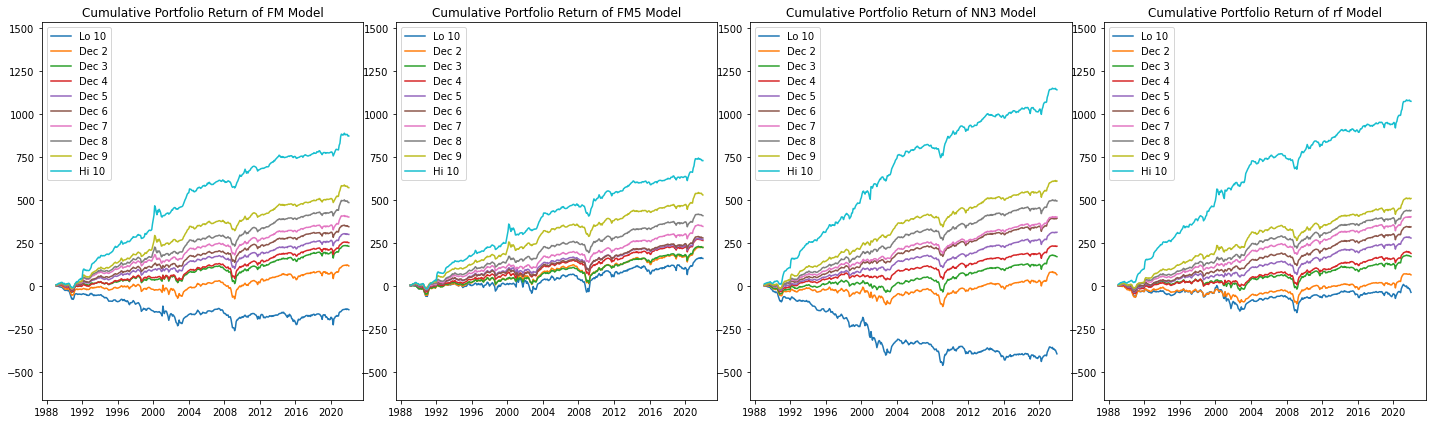

In [57]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of rf Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

## lag price > 2

In [17]:
crsp = pd.read_csv(file_path + 'crsp.csv')
crsp['lag_price'] = crsp.groupby('permno')['prc'].shift(1)

# filter lag price >5 
crsp = crsp[crsp['lag_price']>2].copy()
# filter common stocks
crsp = crsp[crsp['shrcd'].isin([10,11])].copy()

In [18]:
OOSresults = pd.read_csv(file_path + 'OOSresults.csv',index_col=0)
OOSresults = OOSresults.merge(crsp[['permno','yyyymm','lag_price','shrcd','siccd']], on=['permno', 'yyyymm'], how='inner')

OOSresults['date'] = pd.to_datetime(OOSresults['yyyymm'], format='%Y%m')+ pd.offsets.MonthEnd(1)

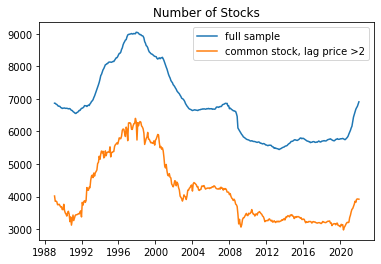

In [34]:
# plot 
plt.plot(FullSample_oos_count, label = 'full sample')
plt.plot(portfolio_analysis_count, label = 'common stock, lag price >2')
plt.title('Number of Stocks')
plt.legend()
plt.show()

In [19]:
# load data
dataset = DataPipeline(file_path)
dataset.data = dataset.data.merge(crsp[['permno','yyyymm','lag_price','shrcd','siccd']], on=['permno', 'yyyymm'], how='inner')
# train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
# train_N = train_mask.sum()
# validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
# validation_N = validation_mask.sum()
# test_mask = (dataset.data['yyyymm'] > 198900)
# test_N = test_mask.sum()
# N = dataset.data.shape[0]

### R-square

#### Naive

In [20]:
OOSresults = OOSresults.assign(pred_naive = naive_prediction(OOSresults))

#### FM

In [23]:
OOSresults = OOSresults.assign(pred_fm = FM_prediction(OOSresults))

#### FM5

In [24]:
OOSresults = OOSresults.assign(pred_fm5 = FM5_prediction(OOSresults))

### OOS R-squared and MSE Summarize

In [25]:
# Initiate a comparison dataframe
comparison = {}
# naive prediction
comparison['Naive'] = {}
comparison['Naive']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_naive'])
comparison['Naive']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_naive'])*100
comparison['FM'] = {}
comparison['FM']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm'])
comparison['FM']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm'])*100
comparison['FM5'] = {}
comparison['FM5']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_fm5'])
comparison['FM5']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_fm5'])*100
comparison['NN3'] = {}
comparison['NN3']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_nn3'])
comparison['NN3']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_nn3'])*100
comparison['RF'] = {}
comparison['RF']['testing MSE'] = MSE(OOSresults['exret'], OOSresults['pred_rf'])
comparison['RF']['testing R2'] = R2(OOSresults['exret'], OOSresults['pred_rf'])*100


In [26]:
pd.DataFrame(comparison).round(2).to_clipboard()
pd.DataFrame(comparison).round(2)

,Naive,FM,FM5,NN3,RF
testing MSE,259.44,262.99,262.13,258.73,258.78
testing R2,0.00,-1.37,-1.04,0.27,0.26


### OOS portfolios

In [43]:
OOSresults['fm_rank'] = OOSresults.groupby('date')['pred_fm'].transform(lambda x: x.rank(pct = True))
OOSresults['fm_portfolio'] = OOSresults.groupby('date')['fm_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm_EW_portfolio = OOSresults.groupby(['date','fm_portfolio'])['exret'].mean().reset_index()
fm_EW_portfolio = fm_EW_portfolio.pivot(index='date', columns='fm_portfolio', values='exret')
fm_EW_portfolio['HML'] = fm_EW_portfolio['Hi 10'] - fm_EW_portfolio['Lo 10'] 
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.58,0.19,0.47,0.61,0.80,0.90,1.10,1.23,1.53,1.86,2.44
bse,0.40,0.31,0.28,0.26,0.26,0.25,0.26,0.27,0.30,0.37,0.38
t_stats,-1.46,0.60,1.66,2.30,3.07,3.60,4.25,4.60,5.18,5.04,6.36
p_value,0.15,0.55,0.10,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.26,0.10,0.28,0.38,0.52,0.59,0.74,0.82,0.92,0.93,1.11


In [44]:
fm_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

In [45]:
OOSresults['fm5_rank'] = OOSresults.groupby('date')['pred_fm5'].transform(lambda x: x.rank(pct = True))
OOSresults['fm5_portfolio'] = OOSresults.groupby('date')['fm5_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

fm5_EW_portfolio = OOSresults.groupby(['date','fm5_portfolio'])['exret'].mean().reset_index()
fm5_EW_portfolio = fm5_EW_portfolio.pivot(index='date', columns='fm5_portfolio', values='exret')
fm5_EW_portfolio['HML'] = fm5_EW_portfolio['Hi 10'] - fm5_EW_portfolio['Lo 10'] 
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

fm5_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,0.02,0.42,0.51,0.65,0.61,0.85,0.93,1.08,1.36,1.68,1.67
bse,0.41,0.32,0.28,0.26,0.25,0.25,0.25,0.25,0.28,0.35,0.31
t_stats,0.04,1.30,1.82,2.48,2.40,3.45,3.76,4.32,4.82,4.77,5.43
p_value,0.97,0.20,0.07,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00
SR,0.01,0.22,0.31,0.41,0.38,0.57,0.64,0.74,0.83,0.88,0.86


In [46]:
fm5_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

In [47]:
OOSresults['nn3_rank'] = OOSresults.groupby('date')['pred_nn3'].transform(lambda x: x.rank(pct = True))
OOSresults['nn3_portfolio'] = OOSresults.groupby('date')['nn3_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

nn3_EW_portfolio = OOSresults.groupby(['date','nn3_portfolio'])['exret'].mean().reset_index()
nn3_EW_portfolio = nn3_EW_portfolio.pivot(index='date', columns='nn3_portfolio', values='exret')
nn3_EW_portfolio['HML'] = nn3_EW_portfolio['Hi 10'] - nn3_EW_portfolio['Lo 10'] 
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

nn3_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.92,0.16,0.51,0.75,0.90,1.09,1.10,1.27,1.48,1.74,2.65
bse,0.47,0.33,0.29,0.25,NaN,0.23,0.23,0.25,0.29,0.37,0.41
t_stats,-1.97,0.48,1.73,2.95,NaN,4.68,4.76,5.16,5.11,4.71,6.52
p_value,0.05,0.63,0.08,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.37,0.08,0.31,0.53,0.65,0.79,0.79,0.88,0.95,0.96,2.00


In [48]:
nn3_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

In [49]:
OOSresults['rf_rank'] = OOSresults.groupby('date')['pred_rf'].transform(lambda x: x.rank(pct = True))
OOSresults['rf_portfolio'] = OOSresults.groupby('date')['rf_rank'].transform(lambda x: pd.cut(x, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
labels=['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']))

rf_EW_portfolio = OOSresults.groupby(['date','rf_portfolio'])['exret'].mean().reset_index()
rf_EW_portfolio = rf_EW_portfolio.pivot(index='date', columns='rf_portfolio', values='exret')
rf_EW_portfolio['HML'] = rf_EW_portfolio['Hi 10'] - rf_EW_portfolio['Lo 10'] 
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2)

rf_portfolio,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,HML
mean,-0.17,0.34,0.56,0.70,0.88,0.91,1.01,1.14,1.27,1.46,1.63
bse,0.43,0.33,0.28,0.26,0.24,0.25,0.23,0.26,0.29,0.39,0.36
t_stats,-0.39,1.02,1.98,2.64,3.60,3.66,4.45,4.36,4.34,3.76,4.51
p_value,0.70,0.31,0.05,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SR,-0.07,0.18,0.33,0.45,0.60,0.64,0.74,0.80,0.82,0.74,1.20


In [50]:
rf_EW_portfolio.apply(newey_west_t_stat, axis=0).round(2).iloc[[0,2,4]].to_clipboard()

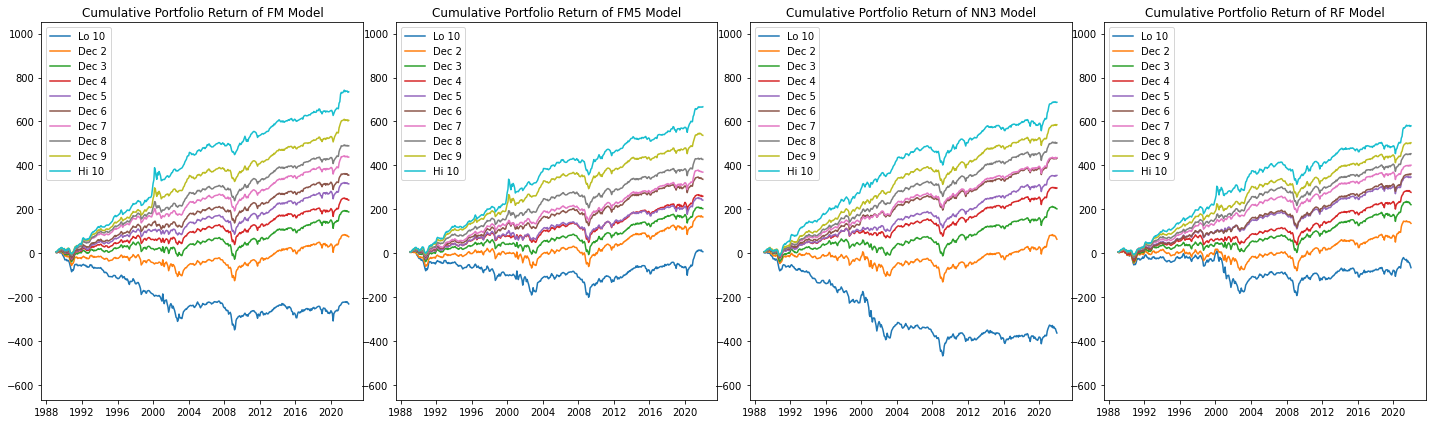

In [51]:
# Calculate the maximum and minimum cumulative sum across all portfolios and quantiles
max_cumsum = max(fm_EW_portfolio.cumsum().max().max(), fm5_EW_portfolio.cumsum().max().max(), nn3_EW_portfolio.cumsum().max().max(), rf_EW_portfolio.cumsum().max().max())
min_cumsum = min(fm_EW_portfolio.cumsum().min().min(), fm5_EW_portfolio.cumsum().min().min(), nn3_EW_portfolio.cumsum().min().min(), rf_EW_portfolio.cumsum().min().min())


fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot each portfolio's cumulative sum on its own subplot
axs[0].plot(fm_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[0].set_title('Cumulative Portfolio Return of FM Model')
axs[0].legend()

axs[1].plot(fm5_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[1].set_title('Cumulative Portfolio Return of FM5 Model')
axs[1].legend()


axs[2].plot(nn3_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].fillna(0).cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[2].set_title('Cumulative Portfolio Return of NN3 Model')
axs[2].legend()

axs[3].plot(rf_EW_portfolio[['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10']].cumsum(),label = ['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9','Hi 10'])
axs[3].set_title('Cumulative Portfolio Return of RF Model')
axs[3].legend()

# Set the same y-axis limits for all subplots based on the max and min calculated
for ax in axs:
    ax.set_ylim(min_cumsum - 200, max_cumsum)


# Improve layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

# Top 1000

In [31]:
dataset.data['lag_me'] = dataset.data.groupby('permno')['me'].shift(1)

In [36]:
dataset.data['me_rank'] = dataset.data.groupby('yyyymm')['lag_me'].transform(lambda x: x.rank(ascending=False))
dataset.data = dataset.data[dataset.data['me_rank']<=1000].copy()

In [37]:
OOSresults = OOSresults.merge(dataset.data[['permno','yyyymm','lag_me']], on=['permno', 'yyyymm'], how='inner')

In [41]:
OOSresults

,yyyymm,permno,me,exret,pred_nn3,pred_rf,lag_price,shrcd,siccd,date,pred_naive,pred_fm,pred_fm5,me_rank,me_lag,lag_me_x,lag_me_y
0,198901,10016,4.220580e+02,4.855406,1.022739,0.545305,74.00000,11.0,3560.0,1989-01-31,0.0,2.826396,1.597730,NaN,NaN,4.004140e+02,4.004140e+02
1,198901,10078,1.441834e+03,13.735715,-0.343687,0.489624,16.62500,11.0,3570.0,1989-01-31,0.0,-0.414471,0.729284,NaN,NaN,1.261605e+03,1.261605e+03
2,198901,10104,1.465010e+03,20.603846,-0.278126,0.532353,19.50000,11.0,7370.0,1989-01-31,0.0,-1.497127,0.763196,NaN,NaN,1.209215e+03,1.209215e+03
3,198901,10107,3.222791e+03,11.421831,-0.493841,0.483559,53.25000,11.0,7370.0,1989-01-31,0.0,-1.084417,0.585277,NaN,NaN,2.878216e+03,2.878216e+03
4,198901,10119,4.492600e+02,5.510606,-0.066316,0.453517,16.50000,11.0,6330.0,1989-01-31,0.0,-0.151970,0.396950,NaN,NaN,4.235880e+02,4.235880e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395995,202112,93330,6.052632e+03,4.149028,1.725473,0.790242,147.14999,11.0,6311.0,2021-12-31,0.0,2.255755,2.314770,797.0,5.810953e+03,5.810953e+03,5.810953e+03
395996,202112,93356,5.125881e+03,0.954608,1.148870,0.689555,140.99001,11.0,9999.0,2021-12-31,0.0,3.234506,1.090416,878.0,5.070565e+03,5.070565e+03,5.070565e+03
395997,202112,93369,7.091981e+03,7.000916,-0.125679,0.439119,23.82000,11.0,8741.0,2021-12-31,0.0,-1.342051,-0.400341,738.0,6.612527e+03,6.612527e+03,6.612527e+03
395998,202112,93374,8.587073e+03,6.137214,1.409975,0.821867,74.18000,11.0,6361.0,2021-12-31,0.0,2.930458,3.233714,657.0,8.142516e+03,8.142516e+03,8.142516e+03


In [38]:
# in OOS result, find the rows that in each yyyymm, sort by me is in top 1000
# OOSresults['me_lag'] = OOSresults.groupby('permno')['me'].shift(1)
# OOSresults['me_rank'] = OOSresults.groupby('yyyymm')['me_lag'].transform(lambda x: x.rank(ascending=False))
# OOSresults_top = OOSresults[OOSresults['me_rank']<=1000].copy()
# Initiate a comparison dataframe
top_comparison = {}
# naive prediction
top_comparison['Naive'] = {}
top_comparison['Naive']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_naive'])
top_comparison['Naive']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_naive'])*100
top_comparison['FM'] = {}
top_comparison['FM']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_fm'])
top_comparison['FM']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_fm'])*100
top_comparison['FM5'] = {}
top_comparison['FM5']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_fm5'])
top_comparison['FM5']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_fm5'])*100
top_comparison['NN3'] = {}
top_comparison['NN3']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_nn3'])
top_comparison['NN3']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_nn3'])*100
top_comparison['RF'] = {}
top_comparison['RF']['testing MSE'] = MSE(OOSresults_top['exret'], OOSresults_top['pred_rf'])
top_comparison['RF']['testing R2'] = R2(OOSresults_top['exret'], OOSresults_top['pred_rf'])*100
pd.DataFrame(top_comparison).round(2).to_clipboard()
pd.DataFrame(top_comparison).round(2)

,Naive,FM,FM5,NN3,RF
testing MSE,119.61,122.96,121.82,118.95,119.03
testing R2,0.00,-2.79,-1.84,0.56,0.49


In [ ]:
## Top 1000 mktcap
## Remove Bottom 1000 mktcap
#(Common Stcok, lag price >2)